In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#pour le preprocessing
import re    # Permet d'enlever les emojis
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# pour construire le model et l'entrainer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#Pour visualiser le résultat
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adri22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df0 = pd.read_csv('/Users/adri22/Desktop/AVA-Bot/src/app/tweets_1_month_ago.csv')
df0

,username,tweet
0,AurelienOhayon,RT @AurelienOhayon: #Bitcoin The 2nd bull run ...
1,hseyin08145489,RT @Tamakittycoin: 💰💰Celebrate the New Year wi...
2,Matteo2102,@JoeTrivella And freedom.\n#Bitcoin
3,MerveeKutay,RT @goatkripto: $TRX Giveaway 🔥\n\n🏆 1 winner ...
4,NenerEUTMF,TwitterCoin vs Bitcoin?? @ssr_srp @NyanCatDoge...
...,...,...
95,StatsMempool,#Bitcoin mempool Tx summary in the last 60 sec...
96,MatteoAstorino2,RT @BitcoinMagazine: 2023 is the year 🙌 #Bitco...
97,JossyEmpire,RT @MartiniGuyYT: #BITCOIN BOTTOM IS IN FOR 20...
98,HODLstarter,Short-Term #Crypto Top-Bottom Index is 10% - B...


In [7]:
df=df0[['tweet']][0:20000]
df

,tweet
0,RT @AurelienOhayon: #Bitcoin The 2nd bull run ...
1,RT @Tamakittycoin: 💰💰Celebrate the New Year wi...
2,@JoeTrivella And freedom.\n#Bitcoin
3,RT @goatkripto: $TRX Giveaway 🔥\n\n🏆 1 winner ...
4,TwitterCoin vs Bitcoin?? @ssr_srp @NyanCatDoge...
...,...
95,#Bitcoin mempool Tx summary in the last 60 sec...
96,RT @BitcoinMagazine: 2023 is the year 🙌 #Bitco...
97,RT @MartiniGuyYT: #BITCOIN BOTTOM IS IN FOR 20...
98,Short-Term #Crypto Top-Bottom Index is 10% - B...


In [8]:
def tweet_to_words(tweet):
    ''' Permet de convertir les tweets en une séquence de mots'''
    

    text = tweet.lower()
    # enlève les caractères
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # on tokenize
    words = text.split()
    # on enlève les stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # on applique stemming
    words = [PorterStemmer().stem(w) for w in words]

    return words

In [9]:
cleantext=[]
#tqdm permet d'avoir la bare de progression
for item in tqdm(df['tweet']):
    words=tweet_to_words(item)
    cleantext+=[words]
df['cleantext']=cleantext
df

100%|██████████| 100/100 [00:00<00:00, 126.77it/s]


,tweet,cleantext
0,RT @AurelienOhayon: #Bitcoin The 2nd bull run ...,"[rt, aurelienohayon, bitcoin, 2nd, bull, run, ..."
1,RT @Tamakittycoin: 💰💰Celebrate the New Year wi...,"[rt, tamakittycoin, celebr, new, year, 100, 00..."
2,@JoeTrivella And freedom.\n#Bitcoin,"[joetrivella, freedom, bitcoin]"
3,RT @goatkripto: $TRX Giveaway 🔥\n\n🏆 1 winner ...,"[rt, goatkripto, trx, giveaway, 1, winner, 50,..."
4,TwitterCoin vs Bitcoin?? @ssr_srp @NyanCatDoge...,"[twittercoin, vs, bitcoin, ssr, srp, nyancatdo..."
...,...,...
95,#Bitcoin mempool Tx summary in the last 60 sec...,"[bitcoin, mempool, tx, summari, last, 60, seco..."
96,RT @BitcoinMagazine: 2023 is the year 🙌 #Bitco...,"[rt, bitcoinmagazin, 2023, year, bitcoin, http..."
97,RT @MartiniGuyYT: #BITCOIN BOTTOM IS IN FOR 20...,"[rt, martiniguyyt, bitcoin, bottom, 2022, pric..."
98,Short-Term #Crypto Top-Bottom Index is 10% - B...,"[short, term, crypto, top, bottom, index, 10, ..."


In [10]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [11]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

#vader permet d'avoir les sentiments des tweets

In [12]:
df2 = compute_vader_scores(df,'cleantext')
df2

,tweet,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,RT @AurelienOhayon: #Bitcoin The 2nd bull run ...,"[rt, aurelienohayon, bitcoin, 2nd, bull, run, ...",0.000,0.745,0.255,0.6249,rt aurelienohayon bitcoin 2nd bull run 2nd gre...
1,RT @Tamakittycoin: 💰💰Celebrate the New Year wi...,"[rt, tamakittycoin, celebr, new, year, 100, 00...",0.000,0.872,0.128,0.2263,rt tamakittycoin celebr new year 100 000 worth...
2,@JoeTrivella And freedom.\n#Bitcoin,"[joetrivella, freedom, bitcoin]",0.000,0.323,0.677,0.6369,joetrivella freedom bitcoin
3,RT @goatkripto: $TRX Giveaway 🔥\n\n🏆 1 winner ...,"[rt, goatkripto, trx, giveaway, 1, winner, 50,...",0.000,0.817,0.183,0.5859,rt goatkripto trx giveaway 1 winner 50 trx 1 f...
4,TwitterCoin vs Bitcoin?? @ssr_srp @NyanCatDoge...,"[twittercoin, vs, bitcoin, ssr, srp, nyancatdo...",0.000,1.000,0.000,0.0000,twittercoin vs bitcoin ssr srp nyancatdog cryp...
...,...,...,...,...,...,...,...
95,#Bitcoin mempool Tx summary in the last 60 sec...,"[bitcoin, mempool, tx, summari, last, 60, seco...",0.000,0.878,0.122,0.3612,bitcoin mempool tx summari last 60 second mean...
96,RT @BitcoinMagazine: 2023 is the year 🙌 #Bitco...,"[rt, bitcoinmagazin, 2023, year, bitcoin, http...",0.000,1.000,0.000,0.0000,rt bitcoinmagazin 2023 year bitcoin http co u2...
97,RT @MartiniGuyYT: #BITCOIN BOTTOM IS IN FOR 20...,"[rt, martiniguyyt, bitcoin, bottom, 2022, pric...",0.000,0.879,0.121,0.0258,rt martiniguyyt bitcoin bottom 2022 price bitc...
98,Short-Term #Crypto Top-Bottom Index is 10% - B...,"[short, term, crypto, top, bottom, index, 10, ...",0.000,0.913,0.087,0.2023,short term crypto top bottom index 10 bottom z...


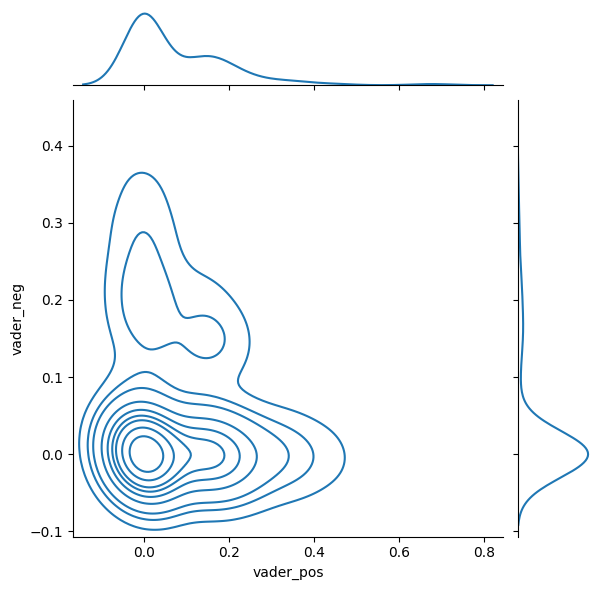

In [21]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neg', kind="kde")

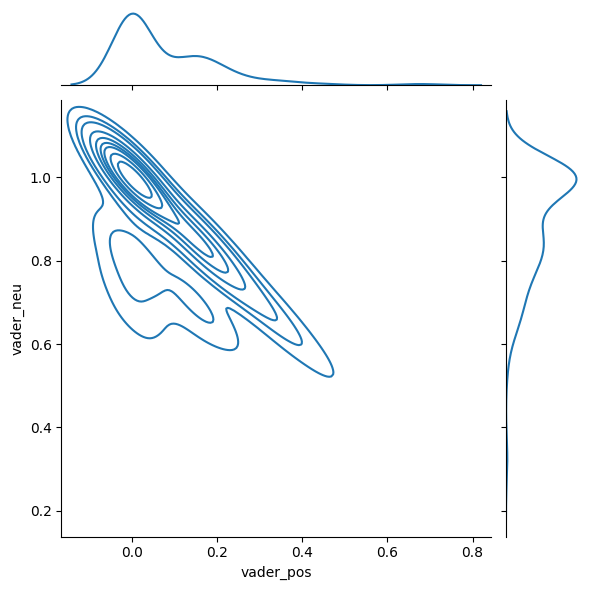

In [22]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neu', kind="kde")

In [23]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_neg']>0:
        class0+=[0]
    elif df2.loc[i,'vader_pos']>0:
        class0+=[2]        
    else:
        class0+=[1]     


In [24]:
df['class']=class0
df['class'].value_counts()

1    49
2    35
0    16
Name: class, dtype: int64

In [25]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    Cette fonction tokenize pour avoir des integers et met de la même taille avec le pad
    '''
    # tokenization du texte
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # on transforme le texte en une séquence d'integers 
    X = tokenizer.texts_to_sequences(text)
    # on met la même longueur avec le padding des phrases
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Avant tokenisation et Padd  \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('Après tokénization \n', X[0])

Avant tokenisation et Padd  
 rt aurelienohayon bitcoin 2nd bull run 2nd great cycl begin http co wcmeasvihg 
Après tokénization 
 [  4 190   1  79  80  42  79 191 192 193   2   3 194   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [28]:
y = pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (60, 50) (60, 3)
Validation Set:  (20, 50) (20, 3)
Test Set:  (20, 50) (20, 3)


In [29]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' calcule la precision '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [31]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [32]:
sgd = SGD(learning_rate=learning_rate, momentum=momentum,  nesterov=False)
# on build le modèle
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))


In [33]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 1.0942 - accuracy: 0.4667 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0691 - val_accuracy: 0.4500 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 133ms/step - loss: 1.0779 - accuracy: 0.5000 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0418 - val_accuracy: 0.4500 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 134ms/step - loss: 1.0526 - accuracy: 0.5000 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0199 - val_accuracy: 0.4500 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 129ms/step - loss: 1.0323 - accuracy: 0.5000 - precision_1: 0


Accuracy  : 0.5000
Precision : 0.5000
Recall    : 0.5000
F1 Score  : 0.5000


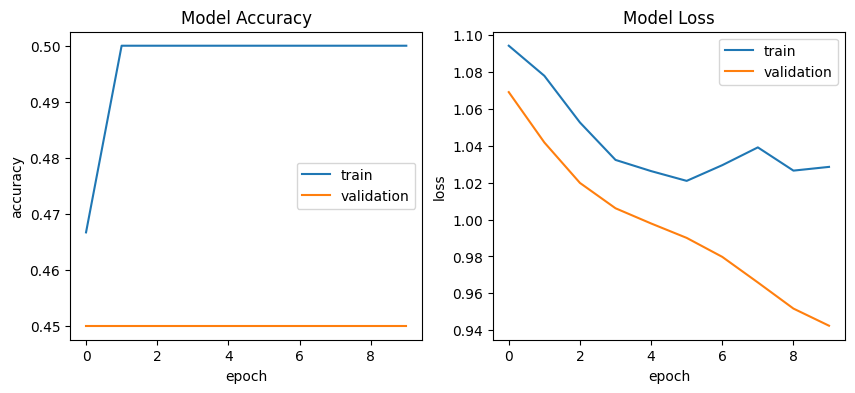

In [34]:
# On evalue le modèle avec test
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# on print les metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

1/1 [==============================] - 0s 68ms/step
1    10
2     6
0     4
dtype: int64
1    20
dtype: int64


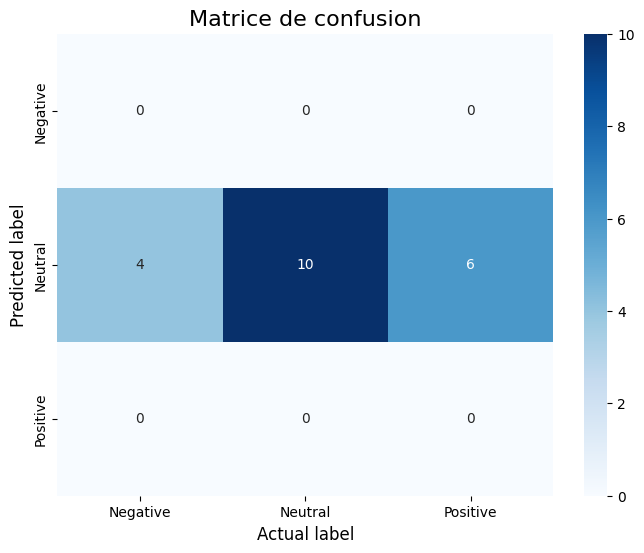

In [36]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''on sort la matrice de confusion avec la data et les anciennes données '''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # on utilise le modèle pour la prédiction
    y_pred = model.predict(X_test)
   
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Matrice de confusion', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)